In [93]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from KVCluster import KVCluster

In [94]:
# Train
train_directory = 'result/train_set'
test_directory = 'result/test_set'
num_clusters = 10

# Test
target_accuracy = 0.60
window_size = 5
resample_rate = 2
inital_throughput = '30'
power_profile_directory = 'result/Dict-Per-Real-Second-Throughput-960.json'

In [95]:
colors = [
    '#e6194B',
    '#f58231',
    '#9A6324',
    '#911eb4',
    '#3cb44b',
    '#f032e6',
    '#4363d8',
]

In [96]:
def load_json_file(file_path):
	try:
		with open(file_path, 'r') as file:
			data = json.load(file)
		return data
	
	except Exception as e:
		print(f"An error occurred while loading the JSON file: {e}")
		return None

In [97]:
def extract_fpss(metric_list):
	return list(metric_list[list(metric_list.keys())[0]][0]['metric'].keys())

In [98]:
def to_accuracy_vector(accuracy_result_seq, fpss, type='F1'):
    accuracy_vector = []
    for fps in fpss:
        accuracy_vector.append(accuracy_result_seq[fps][type])
    
    return accuracy_vector

## Train

In [99]:
train_filenames = sorted(os.listdir(train_directory))
train_video_names = sorted(list(set([f.split('_')[0] for f in train_filenames])))

In [100]:
fpss = extract_fpss(load_json_file(os.path.join(train_directory, train_video_names[0] + "_Accuracy_Result.json")))

cluster = KVCluster(num_clusters)

In [101]:
for v in train_video_names:
	accuracy_result = load_json_file(os.path.join(train_directory, v + "_Accuracy_Result.json"))
	movement_result = load_json_file(os.path.join(train_directory, v + "_Movement_Result.json"))

	for class_idx in list(accuracy_result.keys()):
		for i in range(len(accuracy_result[class_idx])):
			accuracy_vector = to_accuracy_vector(accuracy_result[class_idx][i]['metric'], fpss)

			for fps in fpss:
				movement_vector = movement_result[class_idx][i]['movement'][fps]

				cluster.add(movement_vector, accuracy_vector)

In [102]:
cluster.cluster_average()

/Users/jiaxili/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Test

In [103]:
def column_averages(matrix):
    # Transpose the matrix to get columns as rows
    columns = list(zip(*matrix))
    
    # Calculate the average for each column
    averages = [sum(column) / len(column) for column in columns]
    
    return averages

In [104]:
def remove_all(l, val):
    return [x for x in l if x != val]

In [105]:
def select_throughput(accuracy_vector, target_accuracy, fpss):
    for i in range(len(fpss)):
        if accuracy_vector[i] >= target_accuracy:
            return fpss[i]
    
    return fpss[-1]

In [106]:
def extract_metric_list(metric_list, fpss, feature='F1'):
    result_column = {}
    
    for fps in fpss: 
        result_column[fps] = [clip_metric['metric'][fps][feature] for clip_metric in metric_list]
    
    return result_column

In [107]:
def find_max_index(string_list):
    # Convert each element to integer
    int_list = [int(element) for element in string_list]
    
    # Find index of maximum integer value
    max_index, max_value = max(enumerate(int_list), key=lambda x: x[1])
    
    return max_value

def extract_cheapest_fps(accuracy_dict, fpss, threshold=0.75):
	max_fps = find_max_index(fpss)
	
	cheapest_fpss = []
	for i in range(len(accuracy_dict[fpss[0]])):
		curr_fps = max_fps
		for fps in fpss:
			if accuracy_dict[fps][i] >= threshold and int(fps) < int(curr_fps):
				curr_fps = fps
		
		cheapest_fpss.append(int(curr_fps))
	
	return cheapest_fpss

In [108]:
test_filenames = sorted(os.listdir(test_directory))
test_video_names = sorted(list(set([f.split('_')[0] for f in test_filenames])))

In [109]:
selected_throughput_result = {}

for v in test_video_names:
	movement_result = load_json_file(os.path.join(test_directory, v + "_Movement_Result.json"))

	for class_idx in list(movement_result.keys()):
		movement_list = []
		selected_throughput = []
		last_throughput = inital_throughput
		
		for i in range(len(movement_result[class_idx])):
			if i % resample_rate != 0:
				selected_throughput.append(last_throughput)

				movement_list.append([])
				if len(movement_list) >= window_size:
					movement_list.pop(0)
				continue

			fps_movement_vector = movement_result[class_idx][i]['movement'][last_throughput]
			movement_list.append(fps_movement_vector)
			filtered_movement_list = remove_all(movement_list, [])
			weighted_movement_vector = column_averages(filtered_movement_list)
			suggested_accuracy_vector = cluster.tell(weighted_movement_vector)
			suggested_throughput = select_throughput(suggested_accuracy_vector, target_accuracy, fpss)

			last_throughput = suggested_throughput
			selected_throughput.append(last_throughput)

			if len(movement_list) >= window_size:
				movement_list.pop(0)
		
		selected_throughput_result[v] = [int(x) for x in selected_throughput]
	

In [110]:
min_throughput_result = {}

for v in test_video_names:
	accuracy_result = load_json_file(os.path.join(test_directory, v + "_Accuracy_Result.json"))

	for class_idx in list(accuracy_result.keys()):
		accuracy = extract_metric_list(accuracy_result[class_idx], fpss)
		cheapest_fps = extract_cheapest_fps(accuracy, fpss, target_accuracy)

		min_throughput_result[v] = cheapest_fps

In [111]:
def plot_mutiple_lines(xs, yss, x_label, y_label, y_legends, title, fig_size, label_size=28, font_size=32, legend_size=20):
    fig, ax1 = plt.subplots(figsize=fig_size)

    for i in range(len(yss)):
        ax1.plot(xs, yss[i], color=colors[i], label=y_legends[i])

    ax1.set_xlabel(x_label, fontsize=font_size)
    ax1.set_ylabel(y_label, fontsize=font_size)
    # ax1.set_title(title, fontsize=font_size)
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.legend(fontsize=legend_size)
    plt.grid(True)

    plt.show()

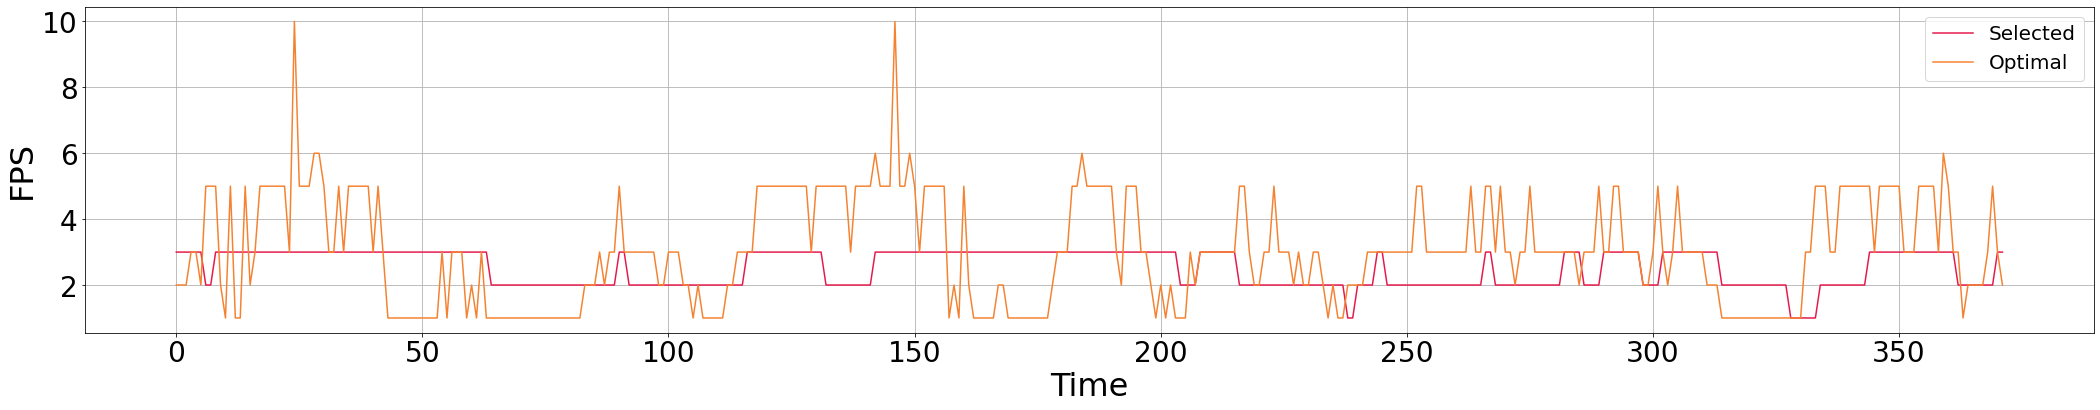

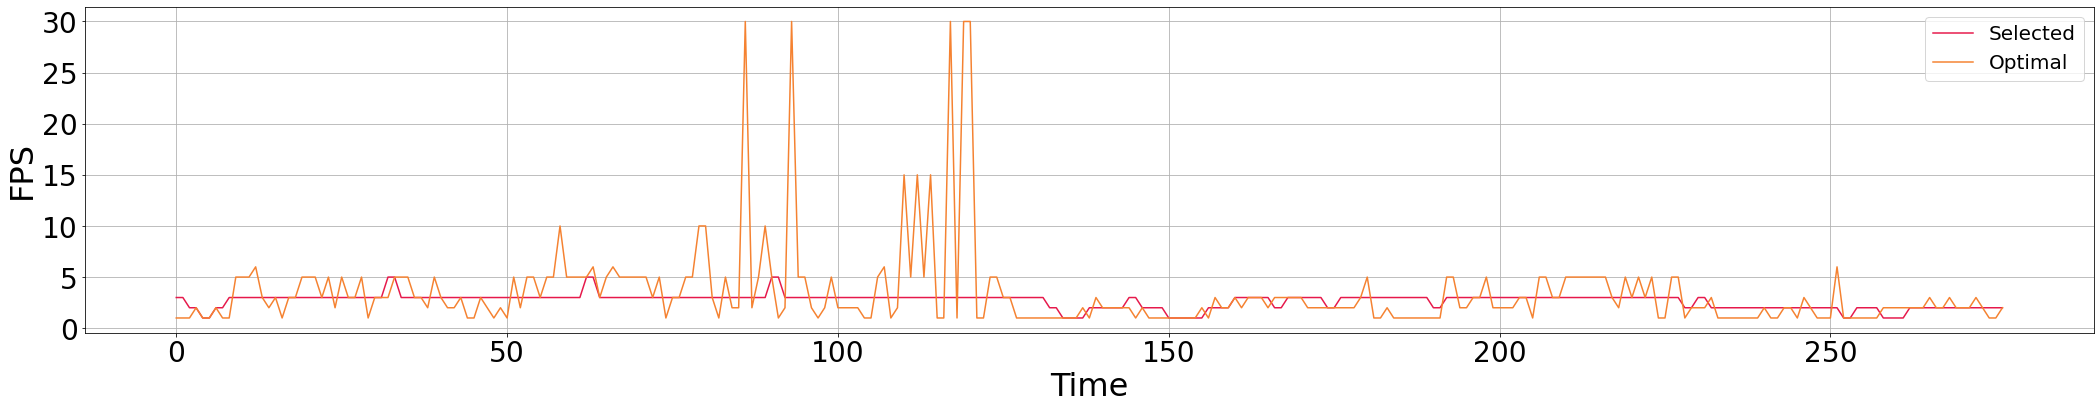

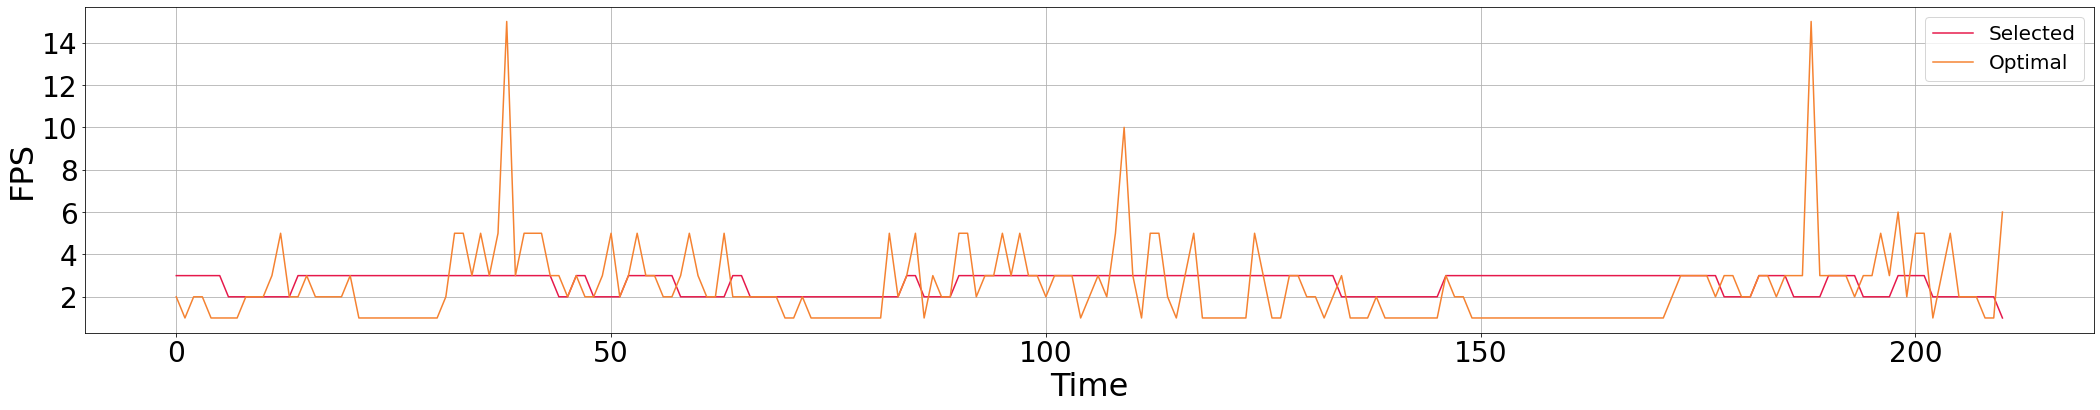

In [112]:
for v in test_video_names:
    selected_throughput = selected_throughput_result[v]
    min_throughput = min_throughput_result[v]
    time = range(0, len(selected_throughput))

    plot_mutiple_lines(time, [selected_throughput, min_throughput], 'Time', 'FPS', ['Selected', 'Optimal'], '', (36, 6))

In [113]:
selected_accuracy_result = {}

for v in test_video_names:
	accuracy_result = load_json_file(os.path.join(test_directory, v + "_Accuracy_Result.json"))

	for class_idx in list(accuracy_result.keys()):
		selected_accuracy_list = []
		for i in range(len(accuracy_result[class_idx])):
			selected_throughput = str(selected_throughput_result[v][i])
			selected_accuracy = accuracy_result[class_idx][i]['metric'][selected_throughput]['F1']
			selected_accuracy_list.append(selected_accuracy)

		selected_accuracy_result[v] = selected_accuracy_list

Average F1 Accuracy: 0.6268248979819869


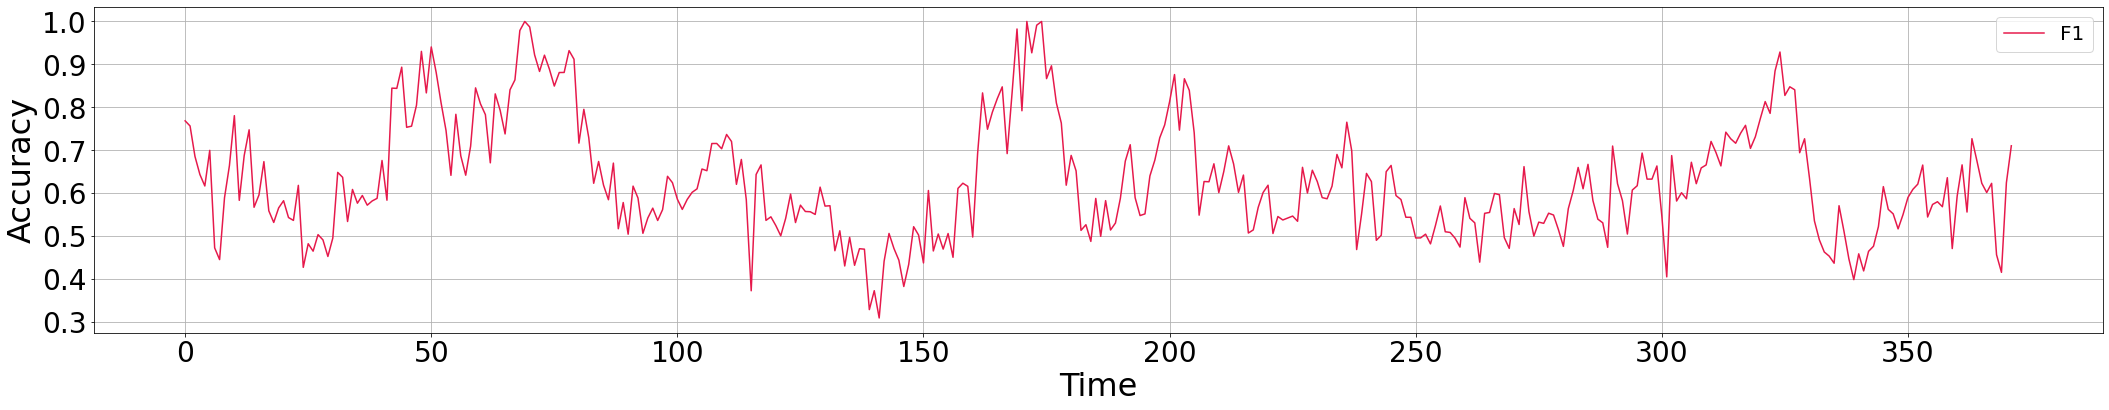

Average F1 Accuracy: 0.6513605874524704


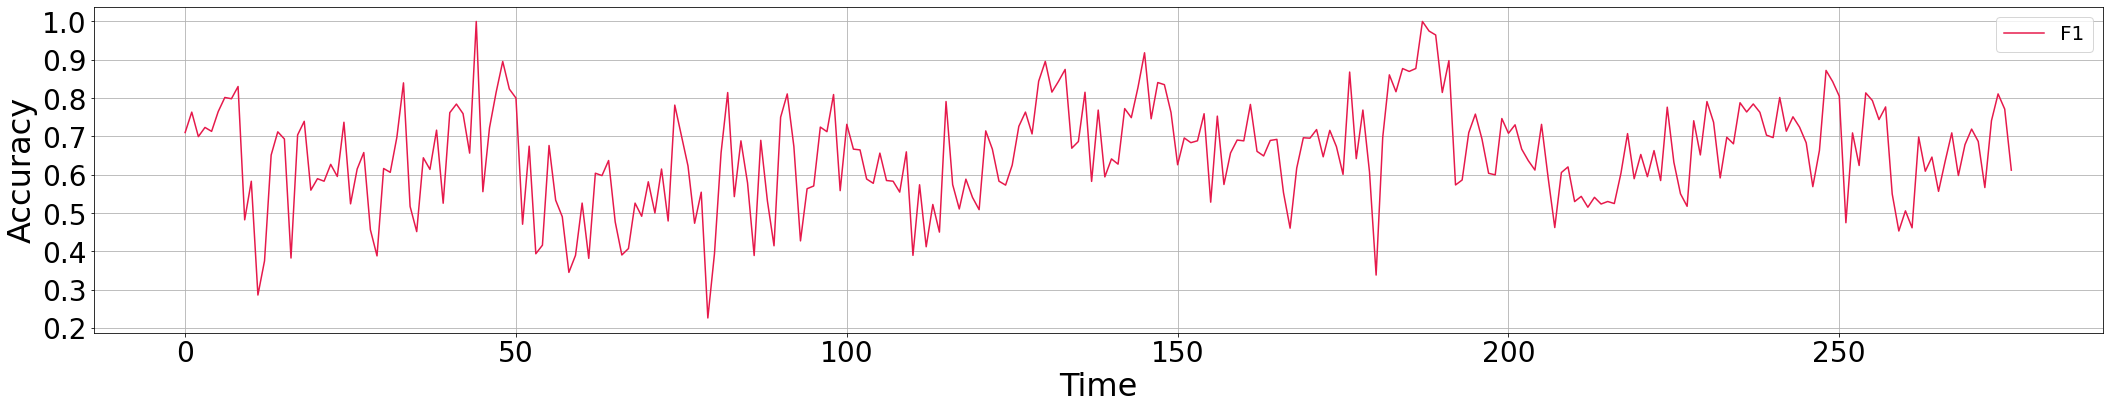

Average F1 Accuracy: 0.6953607009588348


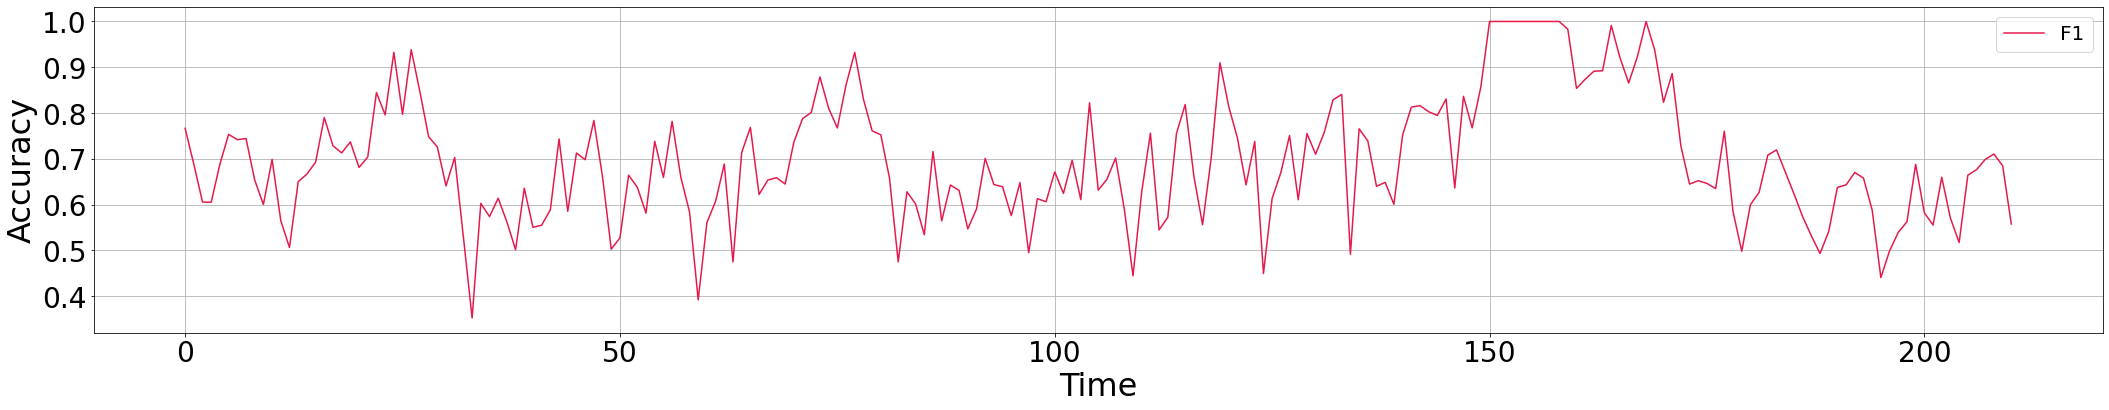

In [114]:
for v in test_video_names:
    selected_accuracy_list = selected_accuracy_result[v]
    time = range(0, len(selected_accuracy_list))

    print(f'Average F1 Accuracy: {np.mean(np.array(selected_accuracy_list))}')
    plot_mutiple_lines(time, [selected_accuracy_list], 'Time', 'Accuracy', ['F1'], '', (36, 6))

Average Power: 3.587237832742673


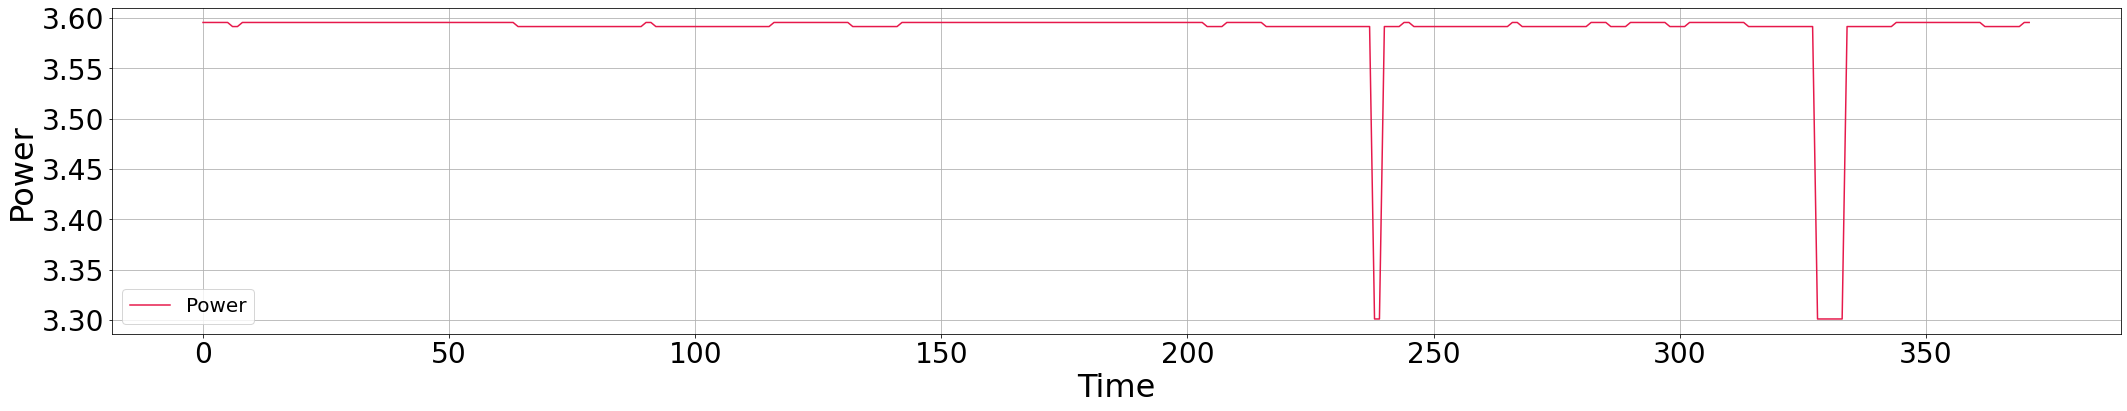

Average Power: 3.5847549049285523


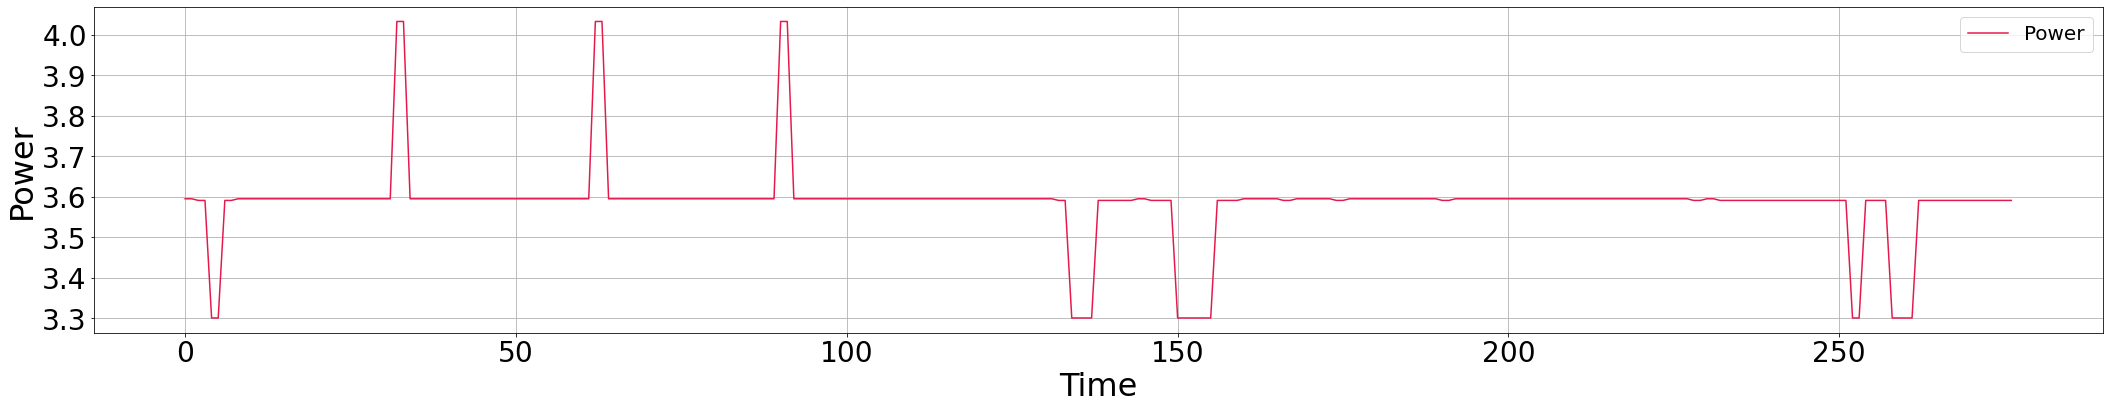

Average Power: 3.5925592196555276


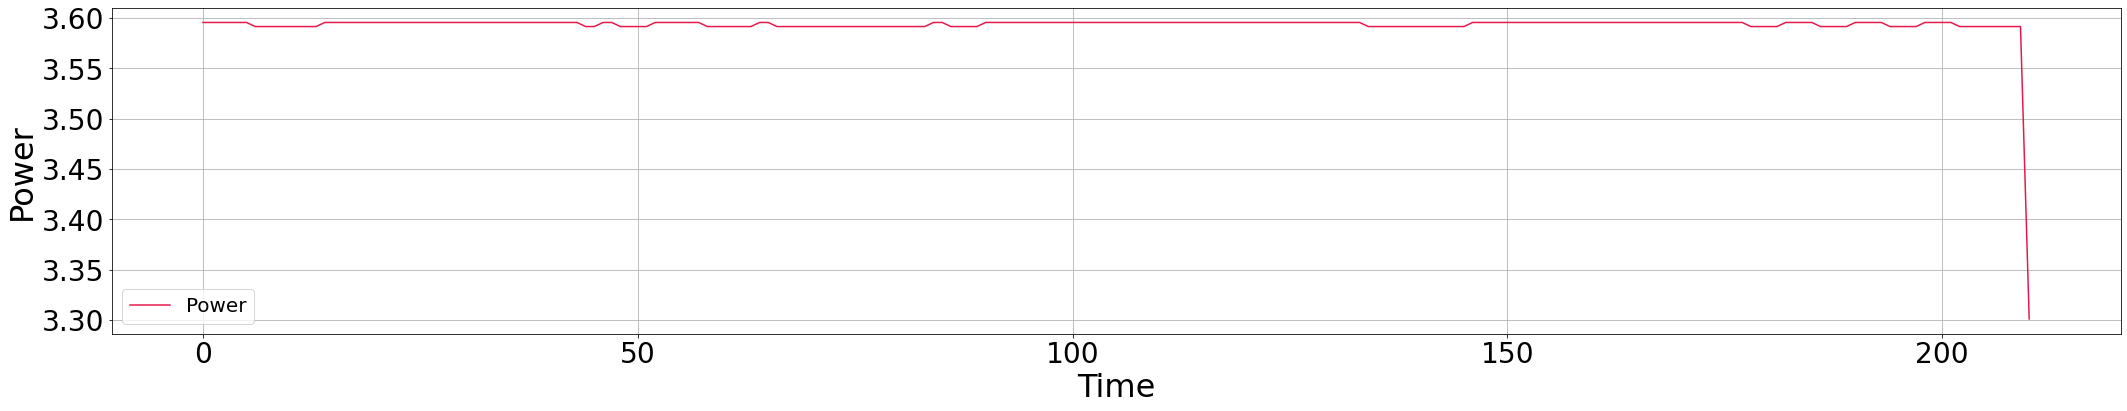

In [115]:
power_profile = load_json_file(os.path.join(power_profile_directory))


for v in test_video_names:
    selected_power = []
    selected_throughput = selected_throughput_result[v]

    for st in selected_throughput:
        if str(st) in power_profile:
            selected_power.append(power_profile[str(st)])
        else:
            selected_power.append(power_profile[str(max([int(k) for k in list(power_profile.keys())]))])

    time = range(0, len(selected_throughput))
    print(f'Average Power: {np.mean(np.array(selected_power))}')
    plot_mutiple_lines(time, [selected_power], 'Time', 'Power', ['Power'], '', (36, 6))